# Test model

In [16]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import torchvision.transforms as transforms

# Load CLIP's image encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define the Vision-Language Projector (MLP)
class VisionLanguageProjector(nn.Module):
    def __init__(self, input_dim=256, output_dim=256):  # Adjusted input_dim to 256 tokens
        super(VisionLanguageProjector, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)  # Output dimension is also 256
        )

    def forward(self, x):
        return self.mlp(x)

# Load and preprocess the style image
style_image_path = "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/NKX3/A2_TMA_15_02_IVB_NKX.png"  # Replace with your image path
style_image = Image.open(style_image_path).convert("RGB")
style_tensor = preprocess(style_image).unsqueeze(0).to(device)

# Extract image features using CLIP's image encoder
with torch.no_grad():
    image_features = model.encode_image(style_tensor)

# Normalize the image features (optional)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)

# Reduce the dimensions to 256 tokens (dimensionality reduction)
# Linear transformation to project the 512-dim feature to 256-dim
linear_projection = nn.Linear(512, 256).to(device)
tokens_256 = linear_projection(image_features)

# Pass the 256 tokens through the Vision-Language Projector
vl_projector = VisionLanguageProjector(input_dim=256, output_dim=256).to(device)
style_embedding = vl_projector(tokens_256)

# Output the shape of the extracted 256-dimensional style embedding (conditional embedding)
print("Extracted Style Embedding (Conditional Embedding) Shape:", style_embedding.shape)


Extracted Style Embedding (Conditional Embedding) Shape: torch.Size([1, 256])


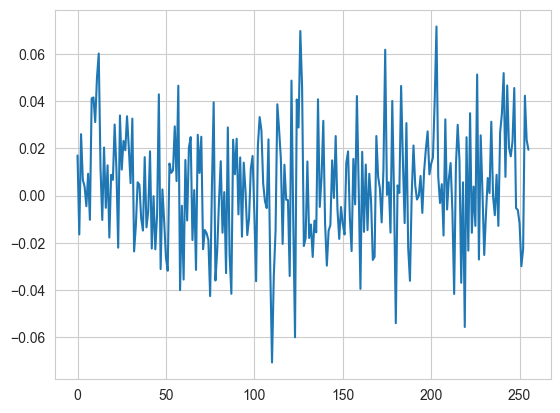

In [19]:
plt.plot(style_embedding[0].detach().numpy())

In [3]:
from transformers import AutoModelForCausalLM
from PIL import Image
import torch

# Set the device to GPU if available, else fallback to MPS or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Load the model and move it to the selected device
model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-01-09",
    trust_remote_code=True,
)

model = model.to(device)

# Open the image and also move it to the same device
image = Image.open('/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/HE/A2_TMA_15_02_IVB_HE.png')

# Assuming the model.encode_image method handles image tensor transformation,
# make sure that the image is passed correctly to the model
enc_image = model.encode_image(image)

# Now, you can query the model for the description
print(model.query(enc_image, "Describe this image."))


{'answer': " The image presents a detailed cross-section of a human body, captured in a pinkish-purple hue. The body is depicted in a circular shape, with the top right corner slightly tilted to the left. The image is filled with numerous small, dark purple/pink spots, which appear to be cells, scattered throughout the body. The cells are not uniformly distributed, with some areas showing a more dense concentration of spots. The background is a stark white, providing a clear contrast to the pinkish-purple tones of the body. The image is a scientific illustration, showcasing the intricate details of the human body's cellular structure."}


In [8]:
import matplotlib.pyplot as plt

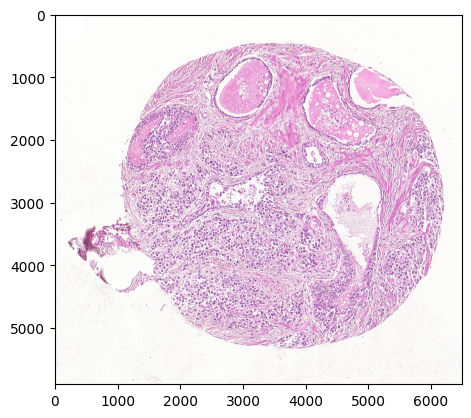

In [9]:
plt.imshow(image)

In [12]:
import torch.nn as nn

In [31]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size=96, patch_size=16, hidden_dim=512):
        super().__init__()
        
        # Store the input image size
        self.img_size = img_size
        
        # Store the size of each patch
        self.patch_size = patch_size
        
        # Calculate the total number of patches
        self.num_patches = (img_size // patch_size) ** 2
        
        # Create a convolutional layer to extract patch embeddings
        # in_channels=3 assumes the input image has 3 color channels (RGB)
        # out_channels=hidden_dim sets the number of output channels to match the hidden dimension
        # kernel_size=patch_size and stride=patch_size ensure each patch is separately embedded
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # Extract patch embeddings from the input image
        X = self.conv(X)
        
        # Flatten the spatial dimensions (height and width) of the patch embeddings
        # This step flattens the patch dimensions into a single dimension
        X = X.flatten(2)
        
        # Transpose the dimensions to obtain the shape [batch_size, num_patches, hidden_dim]
        # This step brings the num_patches dimension to the second position
        X = X.transpose(1, 2)
        
        return X


In [32]:
class Head(nn.Module):
    def __init__(self, n_embd, head_size, dropout=0.1, is_decoder=False):
        super().__init__()
        
        # Linear layer for key projection
        self.key = nn.Linear(n_embd, head_size, bias=False)
        
        # Linear layer for query projection
        self.query = nn.Linear(n_embd, head_size, bias=False)
        
        # Linear layer for value projection
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Flag indicating whether this head is used in the decoder
        self.is_decoder = is_decoder

    def forward(self, x):
        # Get the batch size (B), sequence length (T), and embedding dimension (C) from the input tensor
        B, T, C = x.shape
        
        # Compute key, query, and value projections
        k = self.key(x)   # Shape: [B, T, head_size]
        q = self.query(x) # Shape: [B, T, head_size]
        v = self.value(x) # Shape: [B, T, head_size]
        
        # Compute attention scores by taking the dot product of query and key
        # and scaling by the square root of the embedding dimension
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # Shape: [B, T, T]
        
        if self.is_decoder:
            # If this head is used in the decoder, apply a causal mask to the attention scores
            # to prevent attending to future positions
            tril = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
            wei = wei.masked_fill(tril == 0, float('-inf'))
        
        # Apply softmax to the attention scores to obtain attention probabilities
        wei = F.softmax(wei, dim=-1) # Shape: [B, T, T]
        
        # Apply dropout to the attention probabilities for regularization
        wei = self.dropout(wei)
        
        # Perform weighted aggregation of values using the attention probabilities
        out = wei @ v # Shape: [B, T, head_size]
        
        return out


In [41]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Ensure that the embedding dimension is divisible by the number of heads
        assert n_embd % num_heads == 0, "n_embd must be divisible by num_heads"

        # Create a ModuleList of attention heads
        self.heads = nn.ModuleList([
            Head(n_embd, n_embd // num_heads, dropout, is_decoder)
            for _ in range(num_heads)
        ])

        # Linear layer for projecting the concatenated head outputs
        self.proj = nn.Linear(n_embd, n_embd)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply each attention head to the input tensor
        head_outputs = [h(x) for h in self.heads]

        # Concatenate the outputs from all heads along the last dimension
        out = torch.cat(head_outputs, dim=-1)

        # Apply the projection layer to the concatenated outputs
        out = self.proj(out)

        # Apply dropout to the projected outputs for regularization
        out = self.dropout(out)

        return out

In [42]:
class MLP(nn.Module):
    def __init__(self, n_embd, dropout=0.1, is_decoder=True):
        super().__init__()
        
        # Define the layers of the MLP
        layers = [
            # First linear layer that expands the input dimension from n_embd to 4 * n_embd
            nn.Linear(n_embd, 4 * n_embd),
            
            # Activation function: ReLU if is_decoder is True, else GELU
            nn.ReLU() if is_decoder else nn.GELU(),
            
            # Second linear layer that projects the intermediate dimension back to n_embd
            nn.Linear(4 * n_embd, n_embd),
            
            # Dropout layer for regularization
            nn.Dropout(dropout)
        ]
        
        # Create a sequential container to hold the layers
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the MLP layers
        return self.net(x)


In [34]:
class Block(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()
        
        # Layer normalization for the input to the attention layer
        self.ln1 = nn.LayerNorm(n_embd)
        
        # Multi-head attention module
        self.attn = MultiHeadAttention(n_embd, num_heads, dropout, is_decoder)
        
        # Layer normalization for the input to the FFN
        self.ln2 = nn.LayerNorm(n_embd)
        
        # Feed-forward neural network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand the dimension
            nn.GELU(),  # Activation function
            nn.Linear(4 * n_embd, n_embd),  # Project back to the original dimension
        )

    def forward(self, x):
        original_x = x  # Save the input for the residual connection
        
        # Apply layer normalization to the input
        x = self.ln1(x)
        
        # Apply multi-head attention
        attn_output = self.attn(x)
        
        # Add the residual connection (original input) to the attention output
        x = original_x + attn_output
        
        # Apply layer normalization to the input to the FFN
        x = self.ln2(x)
        
        # Apply the FFN
        ffn_output = self.ffn(x)
        
        # Add the residual connection (input to FFN) to the FFN output
        x = x + ffn_output
        
        return x


In [35]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()
        
        # Patch embedding layer to convert the input image into patches
        self.patch_embedding = PatchEmbeddings(img_size, patch_size, num_hiddens)
        
        # Learnable classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        
        # Calculate the number of patches
        num_patches = (img_size // patch_size) ** 2
        
        # Learnable position embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, num_hiddens))
        
        # Dropout layer for the embeddings
        self.dropout = nn.Dropout(emb_dropout)
        
        # Stack of transformer blocks
        self.blocks = nn.ModuleList([Block(num_hiddens, num_heads, blk_dropout, is_decoder=False) for _ in range(num_blks)])
        
        # Layer normalization for the final representation
        self.layer_norm = nn.LayerNorm(num_hiddens)

    def forward(self, X):
        # Convert the input image into patch embeddings
        x = self.patch_embedding(X)
        
        # Expand the classification token to match the batch size
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        
        # Concatenate the classification token with the patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add the position embedding to the patch embeddings
        x += self.pos_embedding
        
        # Apply dropout to the embeddings
        x = self.dropout(x)
        
        # Pass the embeddings through the transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply layer normalization to the final representation
        x = self.layer_norm(x[:, 0])
        
        return x


In [36]:
class MultiModalProjector(nn.Module):
    def __init__(self, n_embd, image_embed_dim, dropout=0.1):
        super().__init__()
        
        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),
            
            # GELU activation function
            nn.GELU(),
            
            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, n_embd),
            
            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x


In [37]:
class DecoderLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=False):
        super().__init__()

        self.use_images = use_images

        # Token embedding table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        # Position embedding table
        self.position_embedding_table = nn.Embedding(1000, n_embd)

        if use_images:
            # Image projection layer to align image embeddings with text embeddings
            self.image_projection = MultiModalProjector(n_embd, image_embed_dim)

        # Stack of transformer decoder blocks
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, is_decoder=True) for _ in range(n_layer)])

        # Final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)

        # Language modeling head
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, image_embeds=None, targets=None):
        # Get token embeddings from the input indices
        tok_emb = self.token_embedding_table(idx)

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            tok_emb = torch.cat([img_emb, tok_emb], dim=1)

        # Get position embeddings
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)

        # Add position embeddings to token embeddings
        x = tok_emb + pos_emb

        # Pass through the transformer decoder blocks
        x = self.blocks(x)

        # Apply final layer normalization
        x = self.ln_f(x)

        # Get the logits from the language modeling head
        logits = self.lm_head(x)

        if targets is not None:
            if self.use_images and image_embeds is not None:
                # Prepare targets by concatenating a dummy target for the image embedding
                batch_size = idx.size(0)
                targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)

            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss

        return logits

    def generate(self, idx, image_embeds, max_new_tokens):
        # Get the batch size and sequence length
        B, T = idx.shape

        # Initialize the generated sequence with the input indices
        generated = idx

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)
        else:
            current_output = self.token_embedding_table(idx)

        # Generate new tokens iteratively
        for i in range(max_new_tokens):
            # Get the current sequence length
            T_current = current_output.size(1)

            # Get position embeddings for the current sequence length
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)

            # Add position embeddings to the current output
            current_output += current_pos_emb

            # Pass through the transformer decoder blocks
            for block in self.blocks:
                current_output = block(current_output)

            # Get the logits for the last token
            logits = self.lm_head(current_output[:, -1, :])

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample the next token based on the probabilities
            idx_next = torch.multinomial(probs, num_samples=1)

            # Concatenate the generated token to the generated sequence
            generated = torch.cat((generated, idx_next), dim=1)

            # Get the embeddings for the generated token
            idx_next_emb = self.token_embedding_table(idx_next)

            # Concatenate the generated token embeddings to the current output
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated

In [38]:
class VisionLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()
        
        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim
        
        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"
        
        # Initialize the vision encoder (ViT)
        self.vision_encoder = ViT(img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout)
        
        # Initialize the language model decoder (DecoderLanguageModel)
        # self.decoder = DecoderLanguageModel(n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=True)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)
        
        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")
        
        # If targets are provided, compute the logits and loss
        if targets is not None:
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits, None  # Returning None for loss when targets are not provided


    def generate(self, img_array, idx, max_new_tokens):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)
        
        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")
        
        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
        return generated_tokens


In [39]:
class VisionLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()
        
        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim
        
        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"
        
        # Initialize the vision encoder (ViT)
        self.vision_encoder = ViT(img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout)
        
        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = DecoderLanguageModel(n_embd, image_embed_dim, vocab_size, num_heads, n_layer)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)
        
        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")
        
        # If targets are provided, compute the logits and loss
        if targets is not None:
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits, None  # Returning None for loss when targets are not provided

    def generate(self, img_array, idx, max_new_tokens):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)
        
        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")
        
        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
        return generated_tokens


In [46]:
device = 'cpu'

In [47]:
import base64
import io
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init

In [54]:
import torch
import torch.nn as nn

# Assuming ViT and DecoderLanguageModel are already defined or imported

# # Define dummy ViT class to avoid errors (you can replace this with the actual ViT model)
# class ViT(nn.Module):
#     def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout):
#         super().__init__()
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.num_hiddens = num_hiddens
#         self.num_heads = num_heads
#         self.num_blks = num_blks
#         self.emb_dropout = emb_dropout
#         self.blk_dropout = blk_dropout
#         # Dummy implementation
#         self.fc = nn.Linear(img_size * img_size * 3, num_hiddens)  # 3 channels

#     def forward(self, x):
#         # Dummy forward pass, just flattening and passing through a linear layer
#         x = x.flatten(start_dim=1)  # Flatten image to (batch_size, img_size * img_size * 3)
#         return self.fc(x)

# # Dummy DecoderLanguageModel for testing purposes
# class DecoderLanguageModel(nn.Module):
#     def __init__(self, n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=True):
#         super().__init__()
#         self.n_embd = n_embd
#         self.image_embed_dim = image_embed_dim
#         self.vocab_size = vocab_size
#         self.num_heads = num_heads
#         self.n_layer = n_layer

#     def forward(self, idx, image_embeds, targets=None):
#         # Dummy forward pass (return random logits and loss)
#         logits = torch.randn((idx.size(0), self.vocab_size))  # Random logits for testing
#         loss = torch.mean(logits)  # Dummy loss
#         return logits, loss

#     def generate(self, idx, image_embeds, max_new_tokens):
#         # Dummy generation (return random tokens)
#         generated_tokens = torch.randint(0, self.vocab_size, (idx.size(0), max_new_tokens))
#         return generated_tokens

# Initialize the VisionLanguageModel
model = VisionLanguageModel(
    n_embd=512, 
    image_embed_dim=256, 
    vocab_size=10000, 
    n_layer=12, 
    img_size=32, 
    patch_size=8, 
    num_heads=8, 
    num_blks=6, 
    emb_dropout=0.1, 
    blk_dropout=0.1
)

# Create a dummy image tensor of shape (batch_size, 3, 32, 32)
dummy_image = torch.randn(1, 3, 32, 32)

# Create a dummy index tensor (simulating input tokens)
dummy_idx = torch.randint(0, 10000, (1, 10))  # batch_size = 1, sequence_length = 10

# Test the forward pass
logits, loss = model(dummy_image, dummy_idx)
print("Logits:", logits)
print("Loss:", loss)

# Test the generate function
generated_tokens = model.generate(dummy_image, dummy_idx, max_new_tokens=246)
print("Generated Tokens:", generated_tokens)


Logits: tensor([[[-0.4780, -0.5494, -0.1424,  ...,  0.5223, -0.5206,  0.3243],
         [ 1.1166, -0.4371, -0.0248,  ..., -0.7316, -0.6496,  0.9220],
         [ 0.5258, -0.4187,  0.0112,  ...,  0.2368, -0.9675,  0.2448],
         ...,
         [-0.2909,  0.0230, -0.2675,  ...,  0.7868, -0.8100, -0.5766],
         [ 0.2604,  0.1588,  0.7164,  ..., -0.9169, -0.0135,  0.2639],
         [-0.0661, -0.7973, -0.2177,  ..., -0.1414,  0.1552,  0.6794]]],
       grad_fn=<ViewBackward0>)
Loss: None
Generated Tokens: tensor([[1993, 3425, 6926, 6836, 8917, 4533,  706, 2535, 5818, 7953, 7826, 1971,
         3359, 1627, 7545, 9484, 8458, 2306, 6185, 7274, 2368, 1463, 1843, 8339,
         1728, 9595, 1464,  265, 9580, 2686, 7107, 4748, 9104, 6585, 8597, 1576,
         1783, 1171, 3145, 6449, 6386, 2461, 8897, 3361, 9353, 9750, 3368, 8693,
         7302, 8578, 5072,  940, 3021, 8924, 4498,  390, 8025, 8470, 5618,  634,
         5156, 5559, 4751, 3151, 2866, 5667, 3992, 9425, 6712, 3874, 8002, 9832,
   

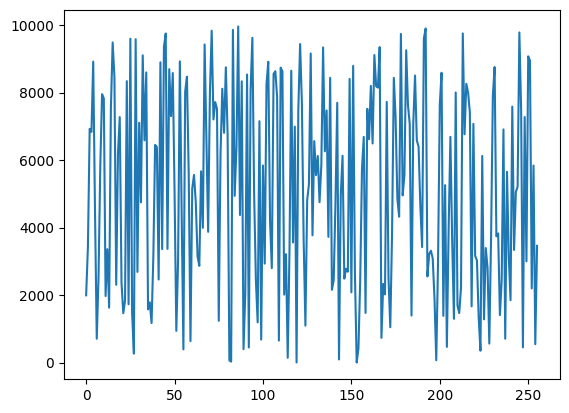

In [56]:
plt.plot(generated_tokens[0].detach().numpy())